In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

In [2]:
import kmod
import kmod.glo as glo
import kmod.plot as plot
import kmod.util as util
import kmod.kernel as kernel

import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.stats as stats
import torch
import torch.autograd
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from kmod.gan_ume_opt import ume_power_criterion

In [3]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
# set this to False to avoid using a GPU
use_cuda = True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
default_type = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
torch.set_default_tensor_type(default_type)

In [5]:
# load a model from the shared folder
shared_resource_path = glo.shared_resource_folder()
model_folder = glo.shared_resource_folder('prob_models', 'mnist_cnn')
epochs = 20
seed = 1
model_fname = 'mnist_cnn_ep{}_s{}.pt'.format(epochs, seed)
model_fpath = os.path.join(model_folder, model_fname)

print('Shared resource path at: {}'.format(shared_resource_path))
print('Model folder: {}'.format(model_folder))
print('Model file: ', model_fname)

Shared resource path at: /nfs/data3/heishiro/Gdrive/kmod_share/
Model folder: /nfs/data3/heishiro/Gdrive/kmod_share/prob_models/mnist_cnn
Model file:  mnist_cnn_ep20_s1.pt


In [6]:
from kmod.mnist.classify import MnistClassifier
# load option depends on whether GPU is used
load_options = {} if use_cuda else {'map_location': lambda storage, loc: storage} 
classifier = MnistClassifier.load(model_fpath, **load_options)
# evaluation mode
classifier = classifier.eval().to(device)
# classifier is a torch.nn.Module
display(classifier)

MnistClassifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [7]:
def norm(x, loc, scale):
    return (x - loc) / scale


def mnist_norm(x):
    return norm(x, 0.1307, 0.3081)


def trans_gan(x):
    y = norm(x, -1.0, 2.0)
    return mnist_norm(y)

def trans_vae(x):
    return mnist_norm(x).view(-1, 1, 28, 28)

def get_trans(model_type):
    name = model_type.lower()
    key_list = ['dcgan', 'began']
    if name not in key_list:
        raise ValueError('Model name has be one of '
                          '{} and was'.format(key_list, name))
        
    if name == 'began':
        return trans_gan
    elif name == 'dcgan':
        return trans_gan
    elif name == 'vae':
        return mnist_norm

In [8]:
from kmod.mnist.dcgan import Generator
from kmod.mnist.dcgan import DCGAN
import kmod.mnist.dcgan as mnist_dcgan
import kmod.net as net
import kmod.gen as gen

def vae_sample(vae, n):
    sample = torch.randn(n, 20).to(device)
    gen_imgs = vae.decode(sample)
    #bern = torch.distributions.Bernoulli(probs=gen_imgs)
    #return bern.sample().view(n, -1, 28, 28)
    return gen_imgs.detach().view(n, -1, 28, 28)

def load_model(model_name, epoch, batch_size=64):
    name = model_name.lower()
    key_list = ['dcgan', 'began']
    if name not in key_list:
        raise ValueError('Model name has be one of '
                          '{} and was'.format(key_list, name))
    print('Loading ', name)
    if name == 'dcgan':
        # load a model from the shared folder
        model_folder = glo.shared_resource_folder('prob_models', 'mnist_dcgan')
        model_fname = 'mnist_dcgan_ep{}_bs{}.pt'.format(epoch, batch_size)
        model_fpath = os.path.join(model_folder, model_fname)
        print('Shared resource path at: {}'.format(shared_resource_path))
        print('Model folder: {}'.format(model_folder))
        print('Model file: ', model_fname)
        # load the generator of type kmod.gen.PTNoiseTransformer
        dcgan = net.SerializableModule.load(model_fpath, **load_options)
        return dcgan
    
    if name == 'began':
        # load a model from the shared folder
        model_folder = glo.shared_resource_folder('prob_models', 'mnist_began', str(epoch))
        model_fname = 'BEGAN_G.pkl'
        model_fpath = os.path.join(model_folder, model_fname)
        print('Shared resource path at: {}'.format(shared_resource_path))
        print('Model folder: {}'.format(model_folder))
        print('Model file: ', model_fname)
        
        from kmod.mnist.began import Generator as BeganGenerator
        # load the generator of type kmod.gen.PTNoiseTransformer
        image_size = 28
        z_dim = 62 #dimention of noise, this is fixed. so don't change
        g = BeganGenerator(input_dim=z_dim,input_size=image_size)
        in_out_shapes = (z_dim, image_size)
        def f_sample_noise(n):
            return torch.rand((n, z_dim))
        g.load(model_fpath, **load_options)
        #print(g.fc[0].weight.is_cuda)
        began = gen.PTNoiseTransformerAdapter(module=g, f_sample_noise=f_sample_noise, 
                                          in_out_shapes=in_out_shapes, tensor_type=default_type)
        return began

## Load models and generate samples

In [9]:
model_type_p = 'began'
epoch = 30
gen_p = load_model(model_type_p, epoch)
model_name_p = '{}_{}'.format(model_type_p, epoch)

Loading  began
Shared resource path at: /nfs/data3/heishiro/Gdrive/kmod_share/
Model folder: /nfs/data3/heishiro/Gdrive/kmod_share/prob_models/mnist_began/30
Model file:  BEGAN_G.pkl


In [10]:
model_type_q = 'began'
epoch = 3
gen_q = load_model(model_type_q, epoch)
model_name_q = '{}_{}'.format(model_type_q, epoch)

Loading  began
Shared resource path at: /nfs/data3/heishiro/Gdrive/kmod_share/
Model folder: /nfs/data3/heishiro/Gdrive/kmod_share/prob_models/mnist_began/3
Model file:  BEGAN_G.pkl


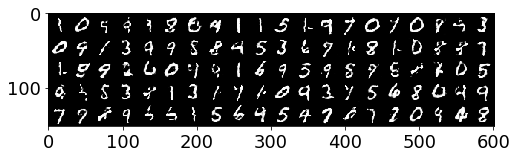

In [11]:
n_gen = 10000
gen_imgs_p = gen_p.sample(n_gen)

n_show = 20*5
plt.figure(figsize=(8, 5))
plot.show_torch_imgs(gen_imgs_p[:n_show], nrow=20, figsize=(8, 5), normalize=True)

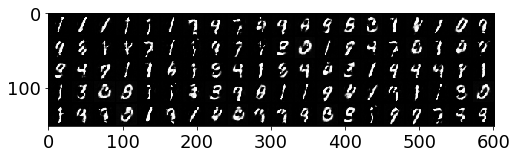

In [12]:
n_gen = 10000
gen_imgs_q = gen_q.sample(n_gen)

n_show = 20*5
plt.figure(figsize=(8, 5))
plot.show_torch_imgs(gen_imgs_q[:n_show], nrow=20, figsize=(8, 5), normalize=True)

## Classify generated samples

In [13]:
trans_p = get_trans(model_type_p)
trans_q = get_trans(model_type_q)

In [14]:
pred_results = []
batch_size = 100


for i in range(0, n_gen, batch_size):
    x = gen_imgs_p[i:i+batch_size]
    x = trans_p(x)
    pred = torch.argmax(classifier(x), dim=1)
    pred_results.append(pred)
pred_results_p = torch.cat(pred_results)
pred_num_p = []
for i in range(10):
    pred_num_p.append(torch.sum(pred_results_p==i).item())

In [15]:
pred_results = []
batch_size = 100
for i in range(0, n_gen, batch_size):
    x = gen_imgs_q[i:i+batch_size]
    x = trans_q(x)
    pred = torch.argmax(classifier(x), dim=1)
    pred_results.append(pred)
pred_results_q = torch.cat(pred_results)
pred_num_q = []
for i in range(10):
    pred_num_q.append(torch.sum(pred_results_q==i).item())

<Container object of 10 artists>

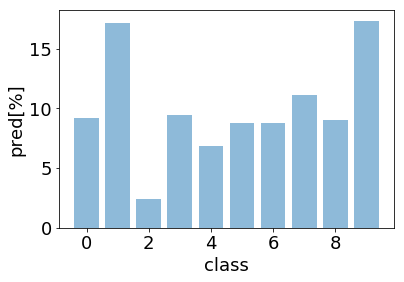

In [16]:
plt.xlabel('class')
plt.ylabel('pred[%]')
plt.bar(np.arange(10), pred_num_p/np.sum(pred_num_p)*100, alpha=0.5)

<Container object of 10 artists>

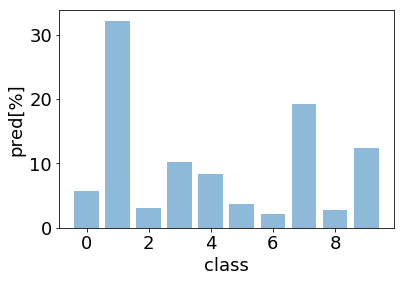

In [17]:
plt.xlabel('class')
plt.ylabel('pred[%]')
plt.bar(np.arange(10), pred_num_q/np.sum(pred_num_q)*100, alpha=0.5)

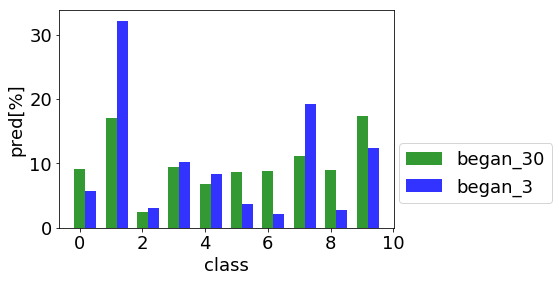

In [18]:
fig, ax = plt.subplots()
index = np.arange(10)
bar_width = 0.35
opacity = 0.8
pred_per_p = pred_num_p / np.sum(pred_num_p) * 100
pred_per_q = pred_num_q / np.sum(pred_num_q) * 100

rects1 = plt.bar(index, pred_per_p, bar_width, alpha=opacity,
                color='g', label=model_name_p)
rects2 = plt.bar(index+bar_width, pred_per_q, bar_width, alpha=opacity,
                color='b', label=model_name_q)
plt.xlabel('class')
plt.ylabel('pred[%]')
ax.legend(loc='right', bbox_to_anchor=(1.5, 0.25))


## Power criterion bar chart

In [19]:
def extractor(imgs):
    """
    Feature extractor
    """
    self = classifier
    x = imgs
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = x.view(-1, 320)
    return x

def extractor_cls(imgs):
    self = classifier
    x = imgs
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    return x

In [20]:
featurizer = extractor_cls
# load MNIST data
mnist_folder = glo.data_file('mnist')
mnist_dataset = torchvision.datasets.MNIST(mnist_folder, train=False, 
                        transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

In [21]:
num_sample = 2000
num_classes = 10
J = 30
reg = 1e-4
n_sample_per_class = num_sample // num_classes
len_data = len(mnist_dataset)
input_Z = []
mnist_Y = torch.stack([mnist_dataset[i][1] for i in range(len_data)])
mnist_X = torch.stack([mnist_dataset[i][0] for i in range(len_data)])

In [22]:
def slice_array(arr, sizes):
    if not sizes or sum(sizes) == 0 or len(sizes) == 0:
        raise ValueError('sizes cannot be empty. Was {}'.format(sizes))
    sub_arrs = []
    idx = 0
    for i in range(0, len(sizes)):
        sub_arrs.append(arr[idx: idx+sizes[i]])
        idx += sizes[i]
    return sub_arrs

In [23]:
num_trials = 100
results = np.empty([num_trials, num_classes])

for i in range(num_trials):
    seed = i
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    X = featurizer(trans_p(gen_p.sample(num_sample)))
    Y = featurizer(trans_q(gen_q.sample(num_sample)))
    #Y = featurizer(mnist_norm(vae_sample(vae, num_sample)))
    V_list = []
    Z_list = []
    for j in range(num_classes):
        idx = (mnist_Y == j)
        rand_idx = util.subsample_ind(len(mnist_Y[idx]), len(mnist_Y[idx]), seed=seed)
        Z, V = slice_array(mnist_X[idx][rand_idx], [n_sample_per_class, J]) 
        Z_list.append(Z)
        V_list.append(V)
    Z = torch.cat(Z_list).to(device)
    Z = featurizer(Z)
    
    XYZ = np.vstack((X.cpu().data.numpy(), Y.cpu().data.numpy(), Z.cpu().data.numpy()))
    med = util.meddistance(XYZ, subsample=1000)
    gwidth2 = torch.tensor(med**2, requires_grad=True, device=device)
    k = kernel.PTKGauss(gwidth2)
    for j in range(num_classes):
        V = V_list[j]
        V = featurizer(V.to(device))
        results[i, j] = ume_power_criterion(X, Y, Z, V, V, k, reg)

<Container object of 10 artists>

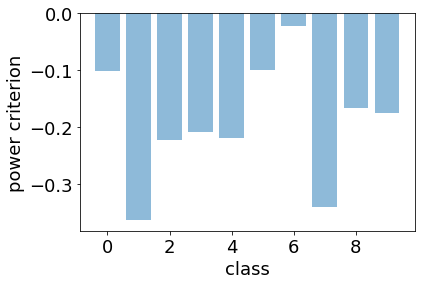

In [24]:
plt.xlabel('class')
plt.ylabel('power criterion')
plt.bar(np.arange(10), np.mean(results, 0), alpha=0.5)

In [25]:
print(np.std(results, 0))

[0.02643558 0.0149914  0.02679745 0.02529314 0.02640226 0.0351609
 0.02295219 0.02051349 0.03813664 0.02936562]
